In [1]:
from itertools import product, combinations, combinations_with_replacement, permutations, zip_longest
from statistics import mean
import collections
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import doctest
#import scipy

In [2]:
d4 = list(range(1,5))
d6 = list(range(1,7))
d8 = list(range(1,9))
d10 = list(range(1,11))
d12 = list(range(1,13))
d20 = list(range(1,21))
d100 = list(range(1,101))

In [3]:
# thinking through average roll values
twodie = list(product(d4,repeat=2))
twodie_totals = [sum(pair) for pair in twodie]
print("{}\n{}".format(twodie, twodie_totals))
print(mean(twodie_totals))

# All in one statement:
mean([sum(pair) for pair in product(d4, repeat=2)])

[(1, 1), (1, 2), (1, 3), (1, 4), (2, 1), (2, 2), (2, 3), (2, 4), (3, 1), (3, 2), (3, 3), (3, 4), (4, 1), (4, 2), (4, 3), (4, 4)]
[2, 3, 4, 5, 3, 4, 5, 6, 4, 5, 6, 7, 5, 6, 7, 8]
5


5

In [4]:
# Read a file with the distribution of monster AC's at any given PC level. 
#    This uses all (or a majority) of the monsters from official D&D
#    sources and assumes that PC's fight monster CRs in the range of 
#    pc_lvl - 5 <= CR <= pc_lvl + 2
ac = (pd.read_csv('monster_ac_distro.csv', header=1)
        .set_index('PC Level')
        .rename_axis('Monster AC', axis='columns')
     )
ac

Monster AC,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,25
PC Level,,,,,,,,,,,,,,,,,,,
1,4,2,1,6,6,28,49,98,96,54,58,30,23,13,2,0,0,0,0
2,4,2,2,6,6,29,51,104,107,64,64,36,28,15,3,1,0,0,0
3,4,2,2,7,7,31,51,109,114,76,80,41,35,20,7,3,0,0,0
4,4,2,2,7,7,32,51,112,119,80,86,42,39,20,8,5,1,0,0
5,1,2,1,4,2,7,22,65,81,67,79,40,44,29,7,5,1,0,0
6,0,2,1,3,2,5,14,52,71,57,76,37,43,33,7,5,1,0,0
7,0,0,1,1,1,4,8,32,49,46,63,36,39,32,7,5,1,0,0
8,1,0,1,1,2,5,3,22,30,34,53,30,36,37,11,5,1,0,0
9,1,0,0,1,2,4,1,16,19,24,51,26,44,38,10,4,1,0,0


## Major functions

In [5]:
def possible_rolls(die, n=1, adv='normal'):  #adv can be 'advantage', 'disadvantage', or 'normal'
    '''
    possible_rolls
    Returns a list of tuples of all possible rolls of dice given the die type ('die') and number 
    of dice rolled ('n').  Each tuple represents one possible roll of 'n' dice of type 'die'
    
    Arguments
    die = integer specifying which die type is used for the roll (e.g. 6 = d6)
    n = integer specifying how many of the 'die' type dice are rolled.
    adv = string of 'normal', 'advantage', or 'disadvantage'. Specifies whether the attack roll is 
          made normally, with advantage, or with disadvantage.  If 'advantage' or 'disadvantage'
          are specified, n should be >=2 and the resulting list of tuples will have tuples of len=1.
          
    >>> possible_rolls(4, n=2)
    [(1, 1), (1, 2), (1, 3), (1, 4), (2, 1), (2, 2), (2, 3), (2, 4), (3, 1), (3, 2), (3, 3), (3, 4), (4, 1), (4, 2), (4, 3), (4, 4)]
    '''
    if adv.lower().startswith('nor'):
        dice_rolls = list(product(list(range(1,die+1)), repeat=n))
        return dice_rolls
    elif adv.lower().startswith('adv'):
        dice_rolls = list(product(list(range(1,die+1)), repeat=max(n,2)))
        return [(max(rolls),) for rolls in dice_rolls]
    elif adv.lower().startswith('dis'):
        dice_rolls = list(product(list(range(1,die+1)), repeat=max(n,2)))
        return [(min(rolls),) for rolls in dice_rolls]
    else:
        raise ValueError("Invalid argument to possible_rolls: adv={}".format(adv))
        
def roll_odds(die, n=1, adv='normal', reroll_nums=[]):
    '''
    Returns a dictionary with every possible role (in a tuple) as the key and the odds
    of rolling that roll as the value.

    Arguments
    die = integer specifying which die type is used for the roll (e.g. 6 = d6)
    n = integer specifying how many of the 'die' type dice are rolled.
    adv = string of 'normal', 'advantage', or 'disadvantage'. Specifies whether the attack roll is 
          made normally, with advantage, or with disadvantage.  If 'advantage' or 'disadvantage'
          are specified, n should be >=2 and the resulting list of tuples will have tuples of len=1.
    reroll_nums = a list of integers which are values which will be rerolled once if rolled.  Does
                  not check to see if these values are valid for "die" type dice.  default=[]

    >>> round(roll_odds(4, n=2)[(3, 2)], 4)
    0.0625
    '''
    return reroll_on_x(possible_rolls(die, n=n, adv=adv), die, x=reroll_nums)

def deprecated_possible_totals(die, n=1, adder=0, adv='normal'): #adv can be 'advantage', 'disadvantage', or 'normal'
    '''
    possible_totals
    Returns a list of integers of all possible totals resulting when 'n' dice of type 'die' are rolled and summed.
        
    Arguments
    die = integer specifying which die type is used for the roll (e.g. 6 = d6)
    n = integer specifying how many of the 'die' type dice are rolled.
    adder = integer specifying additional value added to the die total (e.g. the '4' in 3d6+4)
    adv = string of 'normal', 'advantage', or 'disadvantage'. Specifies whether the attack roll is 
          made normally, with advantage, or with disadvantage.  If 'advantage' or 'disadvantage'
          are specified, n should be >=2 and the resulting list of tuples will have tuples of len=1.
          
    >>> deprecated_possible_totals(4, n=2)
    [2, 3, 4, 5, 3, 4, 5, 6, 4, 5, 6, 7, 5, 6, 7, 8]
    '''
    return [sum(rolls)+adder for rolls in 
             possible_rolls(die, n=n, adv=adv)]

def total_odds(die, n=1, adder=0, adv='normal', reroll_nums=[]):
    '''
    Returns a dictionary with every possible roll total (adding up the die) as the key
    and the odds of rolling that total as the value.

    Arguments
    die = integer specifying which die type is used for the roll (e.g. 6 = d6)
    n = integer specifying how many of the 'die' type dice are rolled.
    adder = integer specifying additional value added to the die total (e.g. the '4' in 3d6+4)
    adv = string of 'normal', 'advantage', or 'disadvantage'. Specifies whether the attack roll is 
          made normally, with advantage, or with disadvantage.  If 'advantage' or 'disadvantage'
          are specified, n should be >=2 and the resulting list of tuples will have tuples of len=1.
    reroll_nums = a list of integers which are values which will be rerolled once if rolled.  Does
                  not check to see if these values are valid for "die" type dice.  default=[]

    >>> test = total_odds(4)
    >>> test[2]
    0.25
    >>> test = total_odds(2, n=2, reroll_nums=[1])
    >>> for k in sorted(test):
    ...     print("({}: {}) ".format(k, test[k]), end='')
    (2: 0.125) (3: 0.375) (4: 0.5) 

    >>> test[4]
    0.5
    '''
    rdict = roll_odds(die, n=n, adv=adv, reroll_nums=reroll_nums)
    return_odds = {}
    for roll, weight in rdict.items():
        #print("Now at roll: {}".format(roll))
        if (sum(roll)+adder) not in return_odds:
            return_odds[sum(roll)+adder] = 0
        return_odds[sum(roll)+adder] += weight
    return return_odds

def avg_roll(die, n=1, adder=0, adv='normal', reroll_nums=[]):
    '''
    Returns an float representing the average value obtained when 'n' dice of type 'die' are rolled
    and then summed (adding in 'adder').
    
    >>> avg_roll(4)
    2.5
    >>> avg_roll(2, n=2, reroll_nums=[1])
    3.375
    '''
    return sum([total * weight for total, weight in total_odds(die, n=n, adder=adder, adv=adv, reroll_nums=reroll_nums).items()])

def deprecated_avg_roll(die, n=1, adder=0, adv='normal'):  #adv can be 'advantage', 'disadvantage', or 'normal'
    '''
    avg_roll
    Returns an float representing the average value obtained when 'n' dice of type 'die' are rolled
    and then summed (adding in 'adder').
    
    Arguments
    die = integer specifying which die type is used for the roll (e.g. 6 = d6)
    n = integer specifying how many of the 'die' type dice are rolled.
    adder = integer specifying additional value added to the die total (e.g. the '4' in 3d6+4)
    adv = string of 'normal', 'advantage', or 'disadvantage'. Specifies whether the attack roll is 
          made normally, with advantage, or with disadvantage.  If 'advantage' or 'disadvantage'
          are specified, n should be >=2 and the resulting list of tuples will have tuples of len=1.
    >>> deprecated_avg_roll(4, n=2)
    5
    '''
    return mean(deprecated_possible_totals(die, n=n, adder=adder, adv=adv))

def chance_to_hit(mod=3, pc_lvl=5, ac_weights=None, adv='normal', reroll_nums=[], ac=None):  #adv can be 'advantage', 'disadvantage', or 'normal'
    '''
    Chance to hit
    Returns the percentage odds that a player will hit with an attack roll,
    given the parameters around that attack roll.
    
    Arguments:
    mod = integer representing the attack modifier (includes proficiency, ability modifier, 
          any +1 bonuses, etc.).
          Defaults to 3.
    pc_lvl = the player character's level.  This level will determine which distribution 
             of likely monster AC's will be used in calculating the odds of hitting.
             Defaults to 5.
    ac_weights = optional dictionary of weights with key=AC and value=% odds of fighting a monster
                 with that AC.  If not provided, will use the % distribution of monsters likely
                 to be encountered given the pc_lvl.
                 Default = None (will use ac_weights appropriate to pc_lvl)
    adv = string of 'normal', 'advantage', or 'disadvantage'. Specifies whether the attack roll is 
          made normally, with advantage, or with disadvantage.
    ac = optional int specifying the AC of the single monster you want to calculate the probability
         of hitting.  If specified, it calculates only against this single AC, not a distribution of
         probably ACs.
         Default = None (do not use single AC, use ac_weights)
    reroll_nums = a list of integers which are values which will be rerolled once if rolled.  Does
                  not check to see if these values are valid for "die" type dice.  default=[]

    >>> round(chance_to_hit(mod=0, ac=10, adv='normal', reroll_nums=[]), 4)
    0.55
    >>> round(chance_to_hit(mod=0, ac=10, adv='advantage', reroll_nums=[]), 4)
    0.7975
    >>> chance_to_hit(mod=0, ac_weights={1:.2, 5:.2, 10:.2, 15:.2, 20:.2}, adv='normal', reroll_nums=[])
    0.54
    >>> round(chance_to_hit(mod=0, ac_weights={1:.2, 5:.2, 10:.2, 15:.2, 20:.2}, adv='normal', reroll_nums=[1]), 4)
    0.557
    '''
    if ac:  #simple case, just calc against one AC
        return sum([weight if roll_total>=ac else 0 for roll_total, weight in total_odds(20, adder=mod, adv=adv, reroll_nums=reroll_nums).items()])
        #hits = [1 if roll>=ac else 0 for roll in deprecated_possible_totals(20, n=1, adder=mod, adv=adv)]
        #return sum(hits)/len(hits)
    if not ac_weights:
        ac_grid = (pd.read_csv('monster_ac_distro.csv', header=1)
            .set_index('PC Level')
            .rename_axis('Monster AC', axis='columns')
        )
        acs = pd.to_numeric(ac_grid.columns).to_list()
        weights = [num/sum(ac_grid.loc[pc_lvl,:]) for num in ac_grid.loc[pc_lvl,:]]
        norm_weights = [w/sum(weights) for w in weights]
        ac_weights = {a:nw for a, nw in zip(acs, norm_weights)}
    ending_odds = []
    for ac, weight_for_this_ac in ac_weights.items():
        hit_odds_for_this_ac = sum([total_weight if total>=ac else 0 
                                    for total, total_weight in 
                                    total_odds(20, adder=mod, adv=adv, reroll_nums=reroll_nums).items()])
        ending_odds.append(hit_odds_for_this_ac * weight_for_this_ac)
        #if adv.lower().startswith('nor'):
        #    hits = [1 if roll>=ac else 0 for roll in deprecated_possible_totals(20, n=1, adder=mod, adv=adv)]
        #else:
        #    hits = [1 if roll>=ac else 0 for roll in deprecated_possible_totals(20, n=2, adder=mod, adv=adv)]
        #odds = sum(hits)/len(hits)
        #ending_odds.append(odds*weight)
    return sum(ending_odds)

def probable_damage(mod=3, pc_lvl=5, adv='normal', ac=None, dmg_die=6, dmg_n=1, dmg_adder=0, dmg_reroll_nums=[]):
    '''
    Probable damage
    Returns the average damage dealt with an attack with given attributes
    
    Arguments:
    mod = integer representing the attack modifier (includes proficiency, ability modifier, 
          any +1 bonuses, etc.).
          Defaults to 3.
    pc_lvl = the player character's level.  This level will determine which distribution 
             of likely monster AC's will be used in calculating the odds of hitting.
             Defaults to 5.
    adv = string of 'normal', 'advantage', or 'disadvantage'. Specifies whether the attack roll is 
          made normally, with advantage, or with disadvantage.
    ac = optional int specifying the AC of the single monster you want to calculate the probable
         damage for.  If not specified, it calculates probable damage against a distribution of
         probable ACs that a PC of level pc_level is likely to encounter.
         Default = None (do not use single AC, use probable distribution of ACs)
    dmg_die = integer specifying which die type is used for damage roll (e.g. 6 = d6)
    dmg_n = integer specifying how many of the dmg_die are rolled.
    dmg_adder = integer specifying additional damage above the die rolls (e.g. the '4' in 3d6+4)
    
    >>> round(probable_damage(mod=0, adv='normal', ac=1, dmg_die=6, dmg_n=1, dmg_reroll_nums=[]), 2)
    3.5
    '''
    #return chance_to_hit(mod=mod, pc_lvl=pc_lvl, ac=ac, adv=adv) * avg_roll(dmg_die, n=dmg_n, adder=dmg_adder)
    return chance_to_hit(mod=mod, pc_lvl=pc_lvl, ac=ac, adv=adv) * avg_roll(dmg_die, n=dmg_n, adder=dmg_adder, reroll_nums=dmg_reroll_nums)

def reroll_on_x(roll_list, die, x=[1], debug=False):
    '''Takes in a list of rolls.  Returns a dictionary of possible rolls (the key) and the 
    odds of getting that role (the value).
    
    Arguments:
    roll_list: a list of tuples representing rolls of dice of type 'die'.  Each roll is a tuple.
    die = integer specifying which die type is used for the roll (e.g. 6 = d6)
    x = list of integers representing values which should be re-rolled and replace with all possible
        results of the re-roll.  For example if one of the rolls inside roll_list is (1, 6) and 'x'=[1]
        and 'die'=6, then the (1,6) entry will be replace with (1,6), (2,6), (3,6), (4,6), (5,6), (6,6).
        I.e. the roll is replaced with all possible outcomes of re-rolling the 1.
        
    This recognizes that rolling a d4 and re-rolling 1s results in the following:
    4 = 25% odds
    3 = 25% odds
    2 = 25% odds
    {1,2,3,4} = split the remaining 25% odds based on the re-roll of the 1.
    Adding this up, it is 6.25% odds of a 1, and 31.25% odds of 2, 3, and 4.
    
    The previous way I was doing this, would not result in these odds, but these are the correct odds.
    >>> test = reroll_on_x(possible_rolls(4), 4)
    >>> sum(test.values())
    1.0
    >>> for k in sorted(test):
    ...     print("({}: {}) ".format(k, test[k]), end='')
    ((1,): 0.0625) ((2,): 0.3125) ((3,): 0.3125) ((4,): 0.3125) 
    >>> test[(1,)]
    0.0625
    >>> test[(2,)]
    0.3125
    >>> test[(3,)]
    0.3125
    >>> test[(4,)]
    0.3125
    >>> test = reroll_on_x(possible_rolls(2, n=2), 2, x=[1])
    >>> sum(test.values())
    1.0
    >>> for k in sorted(test):
    ...     print("({}: {}) ".format(k, test[k]), end='')
    ((1, 1): 0.125) ((1, 2): 0.1875) ((2, 1): 0.1875) ((2, 2): 0.5) 
    >>> test[(1,1)]
    0.125
    >>> test[(1,2)]
    0.1875
    >>> test[(2,1)]
    0.1875
    >>> test[(2,2)]
    0.5
    '''
    odds = {roll: 0 for roll in set(roll_list)}
    for roll in set(roll_list):
        odds[roll] = roll_list.count(roll)/len(roll_list)
    original_odds = odds.copy()
    odds_adders = {roll: 0 for roll in roll_list} # all zeros for now, we'll accumulate adds here
    for roll in odds.keys():
        if debug: print("On roll: {}, odds={}, odds_adders={}".format(roll, odds, odds_adders)) #debug
        if sum([1 for r in roll if r in x]) > 0:
            odds[roll] = 0
            if debug: print("    zeroing out {}, odds={}".format(roll, odds))
            for i, die_result in enumerate(roll):
                if die_result in x:
                    split_odds = original_odds[roll] / (sum([list(roll).count(element) for element in x]) * die)
                    if debug: print("    rerolling {}th element ({}), split will be {} ways".format(i, die_result, sum([list(roll).count(element) for element in x]) * die))  #debug
                    new_rolls = possible_rerolls(roll, i, die)
                    for nr in new_rolls:
                        if debug: print("        adding {} to {}".format(split_odds, nr)) #debug
                        odds_adders[nr] += split_odds
    
    return {k: v+odds_adders[k] for k, v in odds.items()}

def possible_rerolls(roll, i, die):
    '''Returns a list of tuples representing all the possible ways to re-roll the 
    ith element of "roll" using a "die" type die'''
    return_rolls = []
    for new_die_result in range(1,die+1):
        new_roll = list(roll).copy()
        new_roll[i] = new_die_result
        return_rolls.append(tuple(new_roll))
    return return_rolls
                     
    
            
                        
                        
            
            

In [6]:
doctest.testmod()

TestResults(failed=0, attempted=30)

In [7]:
print(possible_rolls(4, n=2))
print(avg_roll(20, n=2, adv='advantage'))

[(1, 1), (1, 2), (1, 3), (1, 4), (2, 1), (2, 2), (2, 3), (2, 4), (3, 1), (3, 2), (3, 3), (3, 4), (4, 1), (4, 2), (4, 3), (4, 4)]
13.825


In [8]:
for adv in ['normal', 'advantage', 'disadvantage']:
    for i in range(2,7):
        print("{}: Attack modifier {} = {:0.0%} chance to hit".format(adv, i, chance_to_hit(mod=i, pc_lvl=5, adv=adv)))

round( avg_roll(6, n=2, adder=3), 1)

normal: Attack modifier 2 = 44% chance to hit
normal: Attack modifier 3 = 49% chance to hit
normal: Attack modifier 4 = 54% chance to hit
normal: Attack modifier 5 = 59% chance to hit
normal: Attack modifier 6 = 64% chance to hit
advantage: Attack modifier 2 = 67% chance to hit
advantage: Attack modifier 3 = 72% chance to hit
advantage: Attack modifier 4 = 77% chance to hit
advantage: Attack modifier 5 = 82% chance to hit
advantage: Attack modifier 6 = 86% chance to hit
disadvantage: Attack modifier 2 = 21% chance to hit
disadvantage: Attack modifier 3 = 25% chance to hit
disadvantage: Attack modifier 4 = 30% chance to hit
disadvantage: Attack modifier 5 = 36% chance to hit
disadvantage: Attack modifier 6 = 42% chance to hit


10.0

In [9]:
pc_lvl = 3
reroll_nums = [1,2]

print("Chance to hit with 2 scenarios")
print("Level {} PC, +5 to hit = {:0.3}".format(pc_lvl, chance_to_hit(mod=5, pc_lvl=pc_lvl, adv='normal')))
print("Level {} PC, +6 to hit = {:0.3}".format(pc_lvl, chance_to_hit(mod=6, pc_lvl=pc_lvl, adv='normal')))

print("\nAverage Damage with 2 scenarios")
print("2d6+3 = {:0.3}".format(avg_roll(6, n=2, adder=3)))
print("d10+4 = {:0.3}".format(avg_roll(10, n=1, adder=4)))


print("\nAverage expected damage with the combination of these scenarios")
print("Level {} PC, +5 to hit, 2d6+3 damage = {:0.3} avg damage".format(pc_lvl, probable_damage(mod=5,
                                                pc_lvl=pc_lvl,
                                                dmg_die=6, 
                                                dmg_n=2, 
                                                dmg_adder=3,
                                                dmg_reroll_nums=[])))
print("Level {} PC, +6 to hit, d10+4 damage = {:0.3} avg damage".format(pc_lvl, probable_damage(mod=6, 
                                                pc_lvl=pc_lvl,
                                                dmg_die=10, 
                                                dmg_n=1, 
                                                dmg_adder=4,
                                                dmg_reroll_nums=[])))

print("\nAverage expected damage if you get to re-roll 1s and 2s (one time)")
print("Level {} PC, +5 to hit, 2d6+3 damage (reroll {}) = {:0.4} avg damage".\
      format(pc_lvl, reroll_nums, probable_damage(mod=5, 
                                                    pc_lvl=pc_lvl,
                                                    dmg_die=6, 
                                                    dmg_n=2, 
                                                    dmg_adder=3,
                                                    dmg_reroll_nums=reroll_nums)
            )
     )
print("Level {} PC, +6 to hit, d10+4 damage (reroll {}) = {:0.4} avg damage".\
      format(pc_lvl, reroll_nums, probable_damage(mod=6, 
                                                    pc_lvl=pc_lvl,
                                                    dmg_die=10, 
                                                    dmg_n=1, 
                                                    dmg_adder=4,
                                                    dmg_reroll_nums=reroll_nums)
            )
     )

print("\nThe same at higher levels:")
for pc_lvl in [4,5,6]:
    print("Level {} PC, +5 to hit, 2d6+3 damage (reroll {}) = {:0.4} avg damage".\
          format(pc_lvl, reroll_nums, probable_damage(mod=5, 
                                                        pc_lvl=pc_lvl,
                                                        dmg_die=6, 
                                                        dmg_n=2, 
                                                        dmg_adder=3,
                                                        dmg_reroll_nums=reroll_nums)
                )
         )
    print("Level {} PC, +6 to hit, d10+4 damage (reroll {}) = {:0.4} avg damage".\
          format(pc_lvl, reroll_nums, probable_damage(mod=6, 
                                                        pc_lvl=pc_lvl,
                                                        dmg_die=10, 
                                                        dmg_n=1, 
                                                        dmg_adder=4,
                                                        dmg_reroll_nums=reroll_nums)
                )
         )
    print("")
    
print("\nThe same at Advantage/Disadvantage:")
pc_lvl = 3
for adv in ['advantage', 'disadvantage']:
    print("{}: Level {} PC, +5 to hit, 2d6+3 damage (reroll {}) = {:0.4} avg damage".\
          format(adv, pc_lvl, reroll_nums, probable_damage(mod=5, 
                                                        pc_lvl=pc_lvl,
                                                        adv=adv,
                                                        dmg_die=6, 
                                                        dmg_n=2, 
                                                        dmg_adder=3,
                                                        dmg_reroll_nums=reroll_nums)
                )
         )
    print("{}: Level {} PC, +6 to hit, d10+4 damage (reroll {}) = {:0.4} avg damage".\
          format(adv, pc_lvl, reroll_nums, probable_damage(mod=6, 
                                                        pc_lvl=pc_lvl,
                                                        adv=adv,
                                                        dmg_die=10, 
                                                        dmg_n=1, 
                                                        dmg_adder=4,
                                                        dmg_reroll_nums=reroll_nums)
                )
         )
    print("")


Chance to hit with 2 scenarios
Level 3 PC, +5 to hit = 0.63
Level 3 PC, +6 to hit = 0.679

Average Damage with 2 scenarios
2d6+3 = 10.0
d10+4 = 9.5

Average expected damage with the combination of these scenarios
Level 3 PC, +5 to hit, 2d6+3 damage = 6.3 avg damage
Level 3 PC, +6 to hit, d10+4 damage = 6.45 avg damage

Average expected damage if you get to re-roll 1s and 2s (one time)
Level 3 PC, +5 to hit, 2d6+3 damage (reroll [1, 2]) = 6.995 avg damage
Level 3 PC, +6 to hit, d10+4 damage (reroll [1, 2]) = 6.994 avg damage

The same at higher levels:
Level 4 PC, +5 to hit, 2d6+3 damage (reroll [1, 2]) = 6.954 avg damage
Level 4 PC, +6 to hit, d10+4 damage (reroll [1, 2]) = 6.956 avg damage

Level 5 PC, +5 to hit, 2d6+3 damage (reroll [1, 2]) = 6.534 avg damage
Level 5 PC, +6 to hit, d10+4 damage (reroll [1, 2]) = 6.569 avg damage

Level 6 PC, +5 to hit, 2d6+3 damage (reroll [1, 2]) = 6.402 avg damage
Level 6 PC, +6 to hit, d10+4 damage (reroll [1, 2]) = 6.447 avg damage


The same at 

In [10]:
def compare_attacks(atk1, atk2,
                    rerolls = [],
                    adv=['normal', 'advantage', 'disadvantage'], 
                    pc_lvls=[3]):
    '''
    compare_attacks
    Prints out chance to hit, avg damage on hit and probable damage for two attacks to compare them.
    Will also repeat the comparison for adv and pc_lvls specified.
    
    Arguments
    atk1: a dictionary which must have 'mod', 'dmg_die', 'dmg_n' & 'dmg_adder' key/values.
    atk2: a dictionary which must have 'mod', 'dmg_die', 'dmg_n' & 'dmg_adder' key/values.
    '''
    ord_ending = {num: ending for num, ending in enumerate(['st','nd','rd']+(['th']*18))}
    if len(adv) > len(pc_lvls): fill = pc_lvls[0]
    else: fill = 'normal'
    for pc_lvl, adv in product(pc_lvls, adv):
        col_width = 25
        num_width = 8
        prec = 1
        print(f"{pc_lvl}{ord_ending[pc_lvl-1]} lvl PC, {adv}, rerolls: {rerolls}\n")
        atk1_description = f"+{atk1['mod']} to hit; {atk1['dmg_n']}d{atk1['dmg_die']}+{atk1['dmg_adder']}"
        atk2_description = f"+{atk2['mod']} to hit; {atk2['dmg_n']}d{atk2['dmg_die']}+{atk2['dmg_adder']}"
        cth1 = chance_to_hit(mod=atk1['mod'], pc_lvl=pc_lvl, adv=adv)
        cth2 = chance_to_hit(mod=atk2['mod'], pc_lvl=pc_lvl, adv=adv)
        adoh1 = avg_roll(atk1['dmg_die'], n=atk1['dmg_n'], 
                               adder=atk1['dmg_adder'], reroll_nums=rerolls)
        adoh2 = avg_roll(atk2['dmg_die'], n=atk2['dmg_n'], 
                               adder=atk2['dmg_adder'], reroll_nums=rerolls)
        pd1 = probable_damage(mod=atk1['mod'], pc_lvl=pc_lvl, adv=adv, dmg_die=atk1['dmg_die'], 
                                    dmg_n=atk1['dmg_n'], dmg_adder=atk1['dmg_adder'], dmg_reroll_nums=rerolls)
        pd2 = probable_damage(mod=atk2['mod'], pc_lvl=pc_lvl, adv=adv, dmg_die=atk2['dmg_die'], 
                                    dmg_n=atk2['dmg_n'], dmg_adder=atk2['dmg_adder'], dmg_reroll_nums=rerolls)
        # column header
        print(f"    {'': >{col_width}}"
              f"{atk1_description}{'': <{col_width-len(atk1_description)}}"
              f"{atk2_description}{'': <{col_width-len(atk2_description)}}" )
        print(f"    {'':->{col_width*3}}")
        # Chance to hit
        print(f"    {'Chance to hit': <{col_width}}"
              f"{cth1:{num_width}.{prec}%}{'': >{col_width-num_width}}"
              f"{cth2:{num_width}.{prec}%}{'': >{col_width-num_width}}" )
        prec = 2
        # Avg damage on hit
        print(f"    {'Avg damage on hit': <{col_width}}"
              f"{adoh1:{num_width}.{prec}f}{'': >{col_width-num_width}}"
              f"{adoh2:{num_width}.{prec}f}{'': >{col_width-num_width}}")
        # Probable damage
        print(f"    {'Probable damage': <{col_width}}"
              f"{pd1:{num_width}.{prec}f}{'': >{col_width-num_width}}"
              f"{pd2:{num_width}.{prec}f}{'': >{col_width-num_width}}")
        print("")
                    

In [26]:
compare_attacks({'mod':5,'dmg_die':6,'dmg_n':2,'dmg_adder':3},
                {'mod':6,'dmg_die':10,'dmg_n':1,'dmg_adder':4},
                pc_lvls=[3,4], rerolls=[1,2])

3rd lvl PC, normal, rerolls: [1, 2]

                             +5 to hit; 2d6+3         +6 to hit; 1d10+4        
    ---------------------------------------------------------------------------
    Chance to hit               63.0%                    67.9%                 
    Avg damage on hit           11.11                    10.30                 
    Probable damage              6.99                     6.99                 

3rd lvl PC, advantage, rerolls: [1, 2]

                             +5 to hit; 2d6+3         +6 to hit; 1d10+4        
    ---------------------------------------------------------------------------
    Chance to hit               84.8%                    88.3%                 
    Avg damage on hit           11.11                    10.30                 
    Probable damage              9.43                     9.10                 

3rd lvl PC, disadvantage, rerolls: [1, 2]

                             +5 to hit; 2d6+3         +6 to hit; 1d10+4       

In [27]:
for rr_list in [[],[1],[1,2],[1,2,3],[1,2,3,4],[1,2,3,4,5],[1,2,3,4,5,6]]:
    print("Level 3 PC, +5 to hit, 2d6+3 damage reroll {}= {:0.4} avg damage".format(rr_list,probable_damage(mod=5,
                                                pc_lvl=3,
                                                dmg_die=6, 
                                                dmg_n=2, 
                                                dmg_adder=3,
                                                dmg_reroll_nums=rr_list)))

Level 3 PC, +5 to hit, 2d6+3 damage reroll []= 6.295 avg damage
Level 3 PC, +5 to hit, 2d6+3 damage reroll [1]= 6.776 avg damage
Level 3 PC, +5 to hit, 2d6+3 damage reroll [1, 2]= 6.995 avg damage
Level 3 PC, +5 to hit, 2d6+3 damage reroll [1, 2, 3]= 7.004 avg damage
Level 3 PC, +5 to hit, 2d6+3 damage reroll [1, 2, 3, 4]= 6.855 avg damage
Level 3 PC, +5 to hit, 2d6+3 damage reroll [1, 2, 3, 4, 5]= 6.601 avg damage
Level 3 PC, +5 to hit, 2d6+3 damage reroll [1, 2, 3, 4, 5, 6]= 6.295 avg damage


In [28]:
for rr_list in [[],[1],[1,2],[1,2,3],[1,2,3,4],[1,2,3,4,5],[1,2,3,4,5,6]]:
    print("Level 3 PC, +6 to hit, 1d10+4 damage reroll {}= {:0.4} avg damage".format(rr_list,probable_damage(mod=6,
                                                pc_lvl=3,
                                                dmg_die=10, 
                                                dmg_n=1, 
                                                dmg_adder=4,
                                                dmg_reroll_nums=rr_list)))

Level 3 PC, +6 to hit, 1d10+4 damage reroll []= 6.451 avg damage
Level 3 PC, +6 to hit, 1d10+4 damage reroll [1]= 6.756 avg damage
Level 3 PC, +6 to hit, 1d10+4 damage reroll [1, 2]= 6.994 avg damage
Level 3 PC, +6 to hit, 1d10+4 damage reroll [1, 2, 3]= 7.164 avg damage
Level 3 PC, +6 to hit, 1d10+4 damage reroll [1, 2, 3, 4]= 7.266 avg damage
Level 3 PC, +6 to hit, 1d10+4 damage reroll [1, 2, 3, 4, 5]= 7.3 avg damage
Level 3 PC, +6 to hit, 1d10+4 damage reroll [1, 2, 3, 4, 5, 6]= 7.266 avg damage


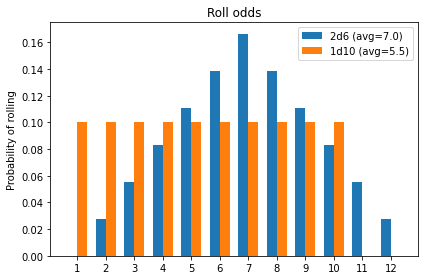

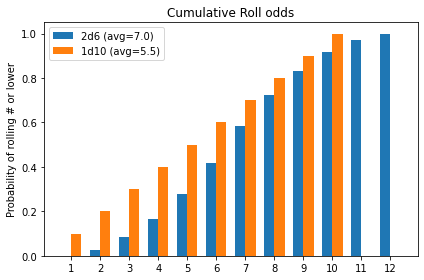

In [29]:
def compare_odds_dist(roll1_odds, roll2_odds, labels=['roll1', 'roll2'], cumulative=False):
    roll_values = set(roll1_odds.keys()) | set(roll2_odds.keys())
    r1_odds = [roll1_odds[k] if k in roll1_odds else 0 for k in roll_values]
    r2_odds = [roll2_odds[k] if k in roll2_odds else 0 for k in roll_values]
    if cumulative:
        r1_odds = [sum(r1_odds[:i+1]) if sum(r1_odds[:i])<0.9999 else 0 for i in range(len(r1_odds))]
        r2_odds = [sum(r2_odds[:i+1]) if sum(r2_odds[:i])<0.9999 else 0 for i in range(len(r2_odds))]

    x = np.arange(len(roll_values))  # the label locations
    width = 0.35  # the width of the bars

    r1_avg = sum([total * weight for total, weight in roll1_odds.items()])
    r2_avg = sum([total * weight for total, weight in roll2_odds.items()])

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, r1_odds, width, label=labels[0]+f" (avg={r1_avg:0.2})")
    rects2 = ax.bar(x + width/2, r2_odds, width, label=labels[1]+f" (avg={r2_avg:0.2})")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Probability of rolling')
    ax.set_title('Roll odds')
    if cumulative:
        ax.set_ylabel('Probability of rolling # or lower')
        ax.set_title('Cumulative Roll odds')
    ax.set_xticks(x)
    ax.set_xticklabels(roll_values)
    ax.legend()

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{:0.3f}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    #autolabel(rects1)
    #autolabel(rects2)


    
    fig.tight_layout()
    plt.show()
    
compare_odds_dist(
    total_odds(6, n=2, adder=0, adv='normal', reroll_nums=[]),
    total_odds(10, n=1, adder=0, adv='normal', reroll_nums=[]),
    labels=['2d6', '1d10']
)
compare_odds_dist(
    total_odds(6, n=2, adder=0, adv='normal', reroll_nums=[]),
    total_odds(10, n=1, adder=0, adv='normal', reroll_nums=[]),
    labels=['2d6', '1d10'],
    cumulative=True
)